##### Creating Dataset

In [2]:
import os
import time
import uuid
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
import json
import albumentations as alb

In [2]:
path = os.path.join('data','images')
number_images = 30
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    _, image = cap.read()
    name = str(uuid.uuid1()) + '.jpg'
    imgnamePath = os.path.join(path,name)
    cv2.imwrite(imgnamePath, image)
    cv2.imshow('Taking Photo', image)
    time.sleep(2)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [3]:
!labelme  

#### Split datas to train,validation,test 

In [129]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [3]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations'))

In [144]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0,0]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### Augmented Data to Tensorflow Dataset

In [27]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    print(byte_img)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (120,120))
    img = img/255
    return img

In [29]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
print(train_images.as_numpy_iterator().next())
train_images = train_images.map(load_image)

print(train_images.as_numpy_iterator().next()) #make all pixels 

b'aug_data\\train\\images\\00b2f189-810e-11ed-b234-70c94e8f3b82.0.jpg'
Tensor("ReadFile:0", shape=(), dtype=string)
[[[0.05055147 0.12898284 0.47322303]
  [0.02634804 0.10471813 0.4406863 ]
  [0.05036765 0.11734068 0.43204656]
  ...
  [0.47843137 0.49411765 0.49019608]
  [0.47205883 0.4877451  0.48382354]
  [0.47745097 0.49313724 0.48921567]]

 [[0.0338848  0.11194853 0.4526348 ]
  [0.03094363 0.10140932 0.43088236]
  [0.03241422 0.09852941 0.40545344]
  ...
  [0.475      0.49068627 0.4867647 ]
  [0.47359067 0.48927698 0.4853554 ]
  [0.48186275 0.49754903 0.49362746]]

 [[0.04705882 0.11764706 0.44767156]
  [0.03964461 0.10575981 0.41954657]
  [0.04761029 0.10159314 0.3985294 ]
  ...
  [0.47549018 0.49117646 0.4872549 ]
  [0.4706495  0.48633578 0.48241422]
  [0.4715686  0.49215686 0.48578432]]

 ...

 [[0.67273283 0.6923407  0.70802695]
  [0.67009807 0.6897059  0.7053922 ]
  [0.6666667  0.6862745  0.7019608 ]
  ...
  [0.5764706  0.62352943 0.60784316]
  [0.5764706  0.61960787 0.6039216

In [30]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)


Tensor("ReadFile:0", shape=(), dtype=string)


In [31]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)


Tensor("ReadFile:0", shape=(), dtype=string)


### Labels

In [32]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [33]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [34]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [35]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [36]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(10860, 10860, 2220, 2220, 2400, 2400)

In [54]:
train = tf.data.Dataset.zip((train_images, train_labels)).shuffle(5000).batch(8)

In [55]:
test = tf.data.Dataset.zip((test_images, test_labels)).shuffle(1300).batch(8)

In [56]:
val = tf.data.Dataset.zip((val_images, val_labels)).shuffle(500).batch(8)

In [53]:
len(list(val.as_numpy_iterator()))

300

In [44]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D,Flatten
from tensorflow.keras.applications import VGG16

In [45]:
vgg = VGG16(include_top=False)

In [36]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [8]:
input_layer = Input(shape=(120,120,3))
    
vgg = VGG16(include_top=False)(input_layer)

In [9]:
vgg.shape

TensorShape([None, 3, 3, 512])

In [11]:
f1 = GlobalMaxPooling2D()(vgg)

print(exp.shape)

(None, 512)
(None, 4608)


<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'global_max_pooling2d_1')>

In [21]:
class1 = Dense(2048, activation='relu')(f1)
class1.shape

TensorShape([None, 2048])

In [22]:
class2 = Dense(1, activation='sigmoid')(class1)
class2.shape

TensorShape([None, 1])

In [23]:
f2 = GlobalMaxPooling2D()(vgg)
f2.shape

TensorShape([None, 512])

In [24]:
class3 = Dense(2048, activation='sigmoid')(f2)
class3.shape

TensorShape([None, 2048])

In [25]:
class4 = Dense(4, activation='sigmoid')(class3)
class4.shape

TensorShape([None, 4])

In [26]:
faceDetector = Model(inputs=input_layer, outputs=[class2, class4])   

In [27]:
faceDetector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [57]:
X, y = train.as_numpy_iterator().next()

In [58]:
X.shape

(8, 120, 120, 3)

In [59]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3223 , 0.08374, 0.8257 , 0.7476 ],
        [0.2017 , 0.336  , 0.4597 , 0.7197 ],
        [0.49   , 0.2715 , 0.8833 , 0.859  ],
        [0.7363 , 0.4011 , 0.903  , 0.684  ],
        [0.3462 , 0.356  , 0.5127 , 0.6387 ],
        [0.555  , 0.2827 , 0.835  , 0.673  ],
        [0.1902 , 0.0884 , 0.669  , 0.741  ],
        [0.2252 , 0.09686, 0.6543 , 0.6934 ]], dtype=float16))

In [60]:
type(train)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [59]:

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = tf.keras.losses.MeanSquaredError()


In [60]:
faceDetector.compile(opt, classloss, regressloss)


In [54]:
hist = faceDetector.fit(train, epochs=10, validation_data=val)

Epoch 1/10
1358/1358 [==============================] - 342s 242ms/step - loss: 0.5351 - dense_5_loss: 0.0233 - dense_7_loss: 0.5118 - dense_5_mean_squared_error: 0.0050 - dense_7_mean_squared_error: 0.0046 - val_loss: 0.5146 - val_dense_5_loss: 0.0023 - val_dense_7_loss: 0.5123 - val_dense_5_mean_squared_error: 7.0741e-04 - val_dense_7_mean_squared_error: 0.0011
Epoch 2/10
1358/1358 [==============================] - 372s 255ms/step - loss: 0.5052 - dense_5_loss: 0.0041 - dense_7_loss: 0.5011 - dense_5_mean_squared_error: 0.0011 - dense_7_mean_squared_error: 0.0013 - val_loss: 0.5149 - val_dense_5_loss: 4.3830e-04 - val_dense_7_loss: 0.5145 - val_dense_5_mean_squared_error: 7.3609e-06 - val_dense_7_mean_squared_error: 0.0018
Epoch 3/10
1358/1358 [==============================] - 401s 278ms/step - loss: 0.5003 - dense_5_loss: 0.0012 - dense_7_loss: 0.4990 - dense_5_mean_squared_error: 3.1440e-04 - dense_7_mean_squared_error: 6.7769e-04 - val_loss: 0.5126 - val_dense_5_loss: 0.0017 - v

### 10.3 Plot Performance

In [55]:
hist.history

{'loss': [0.5351177453994751,
  0.5051733255386353,
  0.5002713203430176,
  0.4983340799808502,
  0.4973633289337158,
  0.4972463846206665,
  0.4971577525138855,
  0.49709901213645935,
  0.49705973267555237,
  0.49703943729400635],
 'dense_5_loss': [0.023347992449998856,
  0.004056566394865513,
  0.0012330412864685059,
  0.0004335490521043539,
  4.550428911898052e-06,
  3.915002707799431e-06,
  2.86816634798015e-06,
  1.8512538417780888e-06,
  1.1859486903631478e-06,
  7.757877824587922e-07],
 'dense_7_loss': [0.5117700099945068,
  0.5011162757873535,
  0.4990384578704834,
  0.4979003369808197,
  0.49735888838768005,
  0.4972420632839203,
  0.49715518951416016,
  0.49709734320640564,
  0.49705857038497925,
  0.49703866243362427],
 'dense_5_mean_squared_error': [0.005042692180722952,
  0.0010873216670006514,
  0.0003143976500723511,
  9.189271804643795e-05,
  1.507225455554817e-09,
  1.2401689675201055e-09,
  5.199082830920077e-10,
  1.9863560796196111e-10,
  6.39852129613594e-11,
  3.4

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [1]:
import os
import time
import uuid
import cv2
from tensorflow.keras.models import load_model
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import argparse
import imutils
import cv2

In [42]:
test_data = test.as_numpy_iterator()
test_data

In [43]:
test_sample = test_data.next()
test_sample

(array([[[[0.5514706 , 0.5593137 , 0.55539215],
          [0.5375613 , 0.54540443, 0.54148287],
          [0.55490196, 0.5627451 , 0.5588235 ],
          ...,
          [0.36421567, 0.08921569, 0.12058824],
          [0.4096201 , 0.08529412, 0.13382353],
          [0.4332108 , 0.08872549, 0.12843138]],
 
         [[0.5532476 , 0.5610907 , 0.55716914],
          [0.5563725 , 0.56421566, 0.5602941 ],
          [0.54558825, 0.5534314 , 0.5495098 ],
          ...,
          [0.31354168, 0.05      , 0.07640931],
          [0.40833333, 0.09944853, 0.1401348 ],
          [0.43039215, 0.08939951, 0.13707107]],
 
         [[0.5576593 , 0.56550246, 0.5615809 ],
          [0.55735296, 0.5651961 , 0.5612745 ],
          [0.56378675, 0.5716299 , 0.5677083 ],
          ...,
          [0.29816177, 0.03982843, 0.0555147 ],
          [0.3707108 , 0.09368873, 0.11672794],
          [0.4153799 , 0.09283088, 0.12567402]],
 
         ...,
 
         [[0.525     , 0.5485294 , 0.5485294 ],
          [0.52156

In [44]:
yhat = faceDetector.predict(test_sample[0])
yhat

1/1 [==============================] - 0s 37ms/step


[array([[0.56996286],
        [0.6582529 ],
        [0.7146617 ],
        [0.6351579 ],
        [0.6304939 ],
        [0.6375346 ],
        [0.64920855],
        [0.5461767 ]], dtype=float32),
 array([[0.41943806, 0.5853786 , 0.5284726 , 0.66239256],
        [0.4075438 , 0.62319446, 0.48261738, 0.55194026],
        [0.3363712 , 0.58940274, 0.46623966, 0.652681  ],
        [0.43396273, 0.50796884, 0.51002693, 0.69783586],
        [0.40393105, 0.55532867, 0.4529487 , 0.66575706],
        [0.4097444 , 0.5944582 , 0.49830192, 0.5692602 ],
        [0.4072049 , 0.6296121 , 0.49636874, 0.6567469 ],
        [0.48536327, 0.50941664, 0.5553785 , 0.6144042 ]], dtype=float32)]

In [63]:
faceDetector = load_model('my_model.hdf5',compile=False)

1/1 [==============================] - 0s 31ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[array([[1.        ],
       [0.9999999 ],
       [0.9999989 ],
       [1.        ],
       [0.99999917],
       [0.9999999 ],
       [1.        ],
       [1.        ]], dtype=float32), array([[0.52328116, 0.3103784 , 0.9186418 , 0.8942038 ],
       [0.43597886, 0.06214816, 0.92041755, 0.72355753],
       [0.05494106, 0.25449613, 0.33037338, 0.62734306],
       [0.17441614, 0.26550028, 0.6659236 , 0.9231527 ],
       [0.00977981, 0.07022214, 0.48243517, 0.720795  ],
       [0.05881971, 0.23223022, 0.3087195 , 0.56002724],
       [0.56323093, 0.27338576, 0.9998951 , 0.89491373],
       [0.47031912, 0.30533266, 0.748341  , 0.68486226]], dtype=float32)]
[array([[1.        ],
       [0.9999999 ],
       [0.9999989 ],
       [1.        ],
       [0.99999917],
       [0.9999999 ],
       [1.        ],
       [1.        ]], dtype=float32), array([[0.52328116, 0.3103784 , 0.9186418 , 0.8942038 ],
       [0.43597886, 0.06214816, 0.92041755, 0.72355753],
       [0.05494106, 0.25449613, 0.3303733

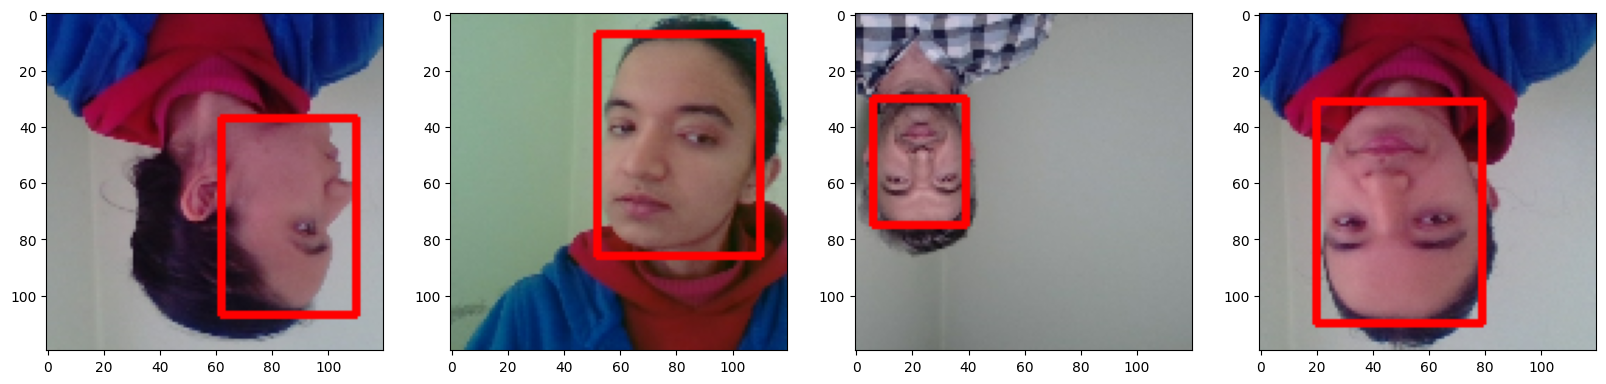

In [67]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = faceDetector.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    print(yhat)
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [4]:
faceDetector.save('facetracker.hdf5')

NameError: name 'faceDetector' is not defined

### 11.3 Real Time Detection

In [2]:
facetracker = load_model('facetracker.hdf5',compile=False)

In [3]:
r = cv2.face.LBPHFaceRecognizer_create()
r.read('model.yml')
names = ['','Yakup','Gulsum','Esra','Hasan'] 

In [13]:
cap = cv2.VideoCapture(0)
cap.set(3, 640) # set video widht
cap.set(4, 480)
count = 0
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500, 50:500,:]
    
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    print(np.multiply(sample_coords, [450,450,450,450]).astype(int)) 
    for [x,y,w,h] in [np.multiply(sample_coords, [450,450,450,450]).astype(int).tolist()]:
        cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
  
   # cv2.imshow('EyeTrack', frame)
    
   # plt.imshow(frame[y:h,x:w], interpolation='nearest')
   # plt.show()
   
    if frame[y:h,x:w] is not None and x>10:
        count+=1
        face = cv2.resize(frame[y:h,x:w],(197,297))
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

        file_name_path = 'C:/Users/acer/Desktop/image/'+'User.2.'+str(count)+'.jpg'

        cv2.imwrite(file_name_path,face)

        
        cv2.putText(face,str(count),(50,50),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
        cv2.imshow('Face Cropper',face)
    elif x<10:
        cv2.putText(face,"No face",(50,50),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
        cv2.imshow('Face Cropper',face)
        pass

    if cv2.waitKey(1)==13 or count==20:
        break
    
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 31ms/step
[0 0 0 0]
1/1 [==============================] - 0s 15ms/step
[0 0 0 0]
1/1 [==============================] - 0s 34ms/step
[0 0 0 0]
1/1 [==============================] - 0s 31ms/step
[0 0 0 0]
1/1 [==============================] - 0s 26ms/step
[0 0 0 0]
1/1 [==============================] - 0s 24ms/step
[0 0 0 0]
1/1 [==============================] - 0s 25ms/step
[0 0 0 0]
1/1 [==============================] - 0s 24ms/step
[0 0 0 0]
1/1 [==============================] - 0s 26ms/step
[0 0 0 0]
1/1 [==============================] - 0s 27ms/step
[0 0 0 0]
1/1 [==============================] - 0s 22ms/step
[0 0 0 0]
1/1 [==============================] - 0s 25ms/step
[0 0 0 0]
1/1 [==============================] - 0s 24ms/step
[0 0 0 0]
1/1 [==============================] - 0s 21ms/step
[0 0 0 0]
1/1 [==============================] - 0s 29ms/step
[0 0 0 0]
1/1 [==============================] - 0s 26ms/step
[0 0 0 0]
1/1 [===

In [4]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500, 50:500,:]
   
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
   
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    print(yhat)
    sample_coords = yhat[1][0]
   
    
    for [x,y,w,h] in [np.multiply(sample_coords, [450,450,450,450]).astype(int).tolist()]:
        try:
            
            gray = cv2.resize(gray[y:h,x:w],(197,297))
            id = "unknown"
            id, confidence = r.predict(gray)
            
            #id, confidence = r.predict(gray[y:h,x:w])
            print(id)
            print(confidence)
            cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame, 
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                        [0,-30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                        [80,0])), 
                                (255,0,0), -1)
            
            if  yhat[0] > 0.5  and confidence<120:
                
                id = names[id]

                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                
            else:
                id = "unknown"


                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
                
            print(id)
            #print(gray.shape)
            #plt.imshow(gray, interpolation='nearest')
            #plt.show()
        except:
            pass
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 12s 12s/step
[array([[0.9863707]], dtype=float32), array([[0.21732694, 0.15977612, 0.7132509 , 0.6875588 ]], dtype=float32)]
4
92.49050968810249
Hasan
1/1 [==============================] - 0s 185ms/step
[array([[0.28659806]], dtype=float32), array([[0.02469627, 0.0207416 , 0.1111961 , 0.11792599]], dtype=float32)]
2
176.92265393257787
unknown
1/1 [==============================] - 0s 21ms/step
[array([[0.22274753]], dtype=float32), array([[0.02053196, 0.01791307, 0.09042361, 0.09900136]], dtype=float32)]
4
195.77086054745763
unknown
1/1 [==============================] - 0s 25ms/step
[array([[0.16190775]], dtype=float32), array([[0.01601971, 0.01408935, 0.06882708, 0.07575765]], dtype=float32)]
4
204.97172302748288
unknown
1/1 [==============================] - 0s 25ms/step
[array([[0.21361448]], dtype=float32), array([[0.01919873, 0.01644704, 0.08472811, 0.09148533]], dtype=float32)]
4
198.3467446217384
unknown
1/1 [=============================

## Learning Rate 0.1 

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.1)
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = tf.keras.losses.MeanSquaredError()

In [20]:
faceDetector.compile(opt, classloss, regressloss)

In [24]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [25]:
hist = faceDetector.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
1358/1358 [==============================] - 333s 198ms/step - loss: 4.8761 - dense_1_loss: 0.5059 - dense_3_loss: 4.3702 - dense_1_mean_squared_error: 0.0333 - dense_3_mean_squared_error: 0.1185 - val_loss: 4.8052 - val_dense_1_loss: 0.3812 - val_dense_3_loss: 4.4240 - val_dense_1_mean_squared_error: 0.0250 - val_dense_3_mean_squared_error: 0.1177
Epoch 2/10
1358/1358 [==============================] - 355s 240ms/step - loss: 4.8788 - dense_1_loss: 0.5055 - dense_3_loss: 4.3733 - dense_1_mean_squared_error: 0.0332 - dense_3_mean_squared_error: 0.1186 - val_loss: 4.8052 - val_dense_1_loss: 0.3812 - val_dense_3_loss: 4.4240 - val_dense_1_mean_squared_error: 0.0250 - val_dense_3_mean_squared_error: 0.1177
Epoch 3/10
1358/1358 [==============================] - 586s 420ms/step - loss: 4.8788 - dense_1_loss: 0.5055 - dense_3_loss: 4.3733 - dense_1_mean_squared_error: 0.0331 - dense_3_mean_squared_error: 0.1185 - val_loss: 4.8052 - val_dense_1_loss: 0.3812 - val_dense_3_loss: 4.4

In [ ]:
faceDetector.save('model_learningRateZeroPointOne.hdf5')

In [44]:
facetracker = load_model('model_unit512.hdf5',compile=False)

In [45]:
r = cv2.face.LBPHFaceRecognizer_create()
r.read('model.yml')
names = ['','Yakup','Gulsum','Esra','Hasan'] 

In [46]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500, 50:500,:]
   
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
   
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    print(yhat)
    sample_coords = yhat[1][0]
    print(sample_coords)
    
    for [x,y,w,h] in [np.multiply(sample_coords, [450,450,450,450]).astype(int).tolist()]:
        try:
            
            gray = cv2.resize(gray[y:h,x:w],(197,297))
            id = "unknown"
            id, confidence = r.predict(gray)
            
            #id, confidence = r.predict(gray[y:h,x:w])
            print(id)
            print(confidence)
            cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame, 
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                        [0,-30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                        [80,0])), 
                                (255,0,0), -1)
            
            if  yhat[0] > 0.5  and confidence<120:
                
                id = names[id]

                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                
            else:
                id = "unknown"


                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
                
            print(id)
            #print(gray.shape)
            #plt.imshow(gray, interpolation='nearest')
            #plt.show()
        except:
            pass
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 370ms/step
[array([[0.9968021]], dtype=float32), array([[0.5790958, 0.3314737, 0.9508664, 0.8498876]], dtype=float32)]
[0.5790958 0.3314737 0.9508664 0.8498876]
4
112.60092808316871
Hasan
1/1 [==============================] - 0s 43ms/step
[array([[0.99977916]], dtype=float32), array([[0.56179166, 0.38177305, 0.96130437, 0.8934395 ]], dtype=float32)]
[0.56179166 0.38177305 0.96130437 0.8934395 ]
2
67.20395146768413
Gulsum
1/1 [==============================] - 0s 23ms/step
[array([[0.99981314]], dtype=float32), array([[0.5604064 , 0.38045314, 0.9620889 , 0.8942034 ]], dtype=float32)]
[0.5604064  0.38045314 0.9620889  0.8942034 ]
2
68.11690632746118
Gulsum
1/1 [==============================] - 0s 31ms/step
[array([[0.9998109]], dtype=float32), array([[0.5591259 , 0.37938762, 0.9616606 , 0.8919551 ]], dtype=float32)]
[0.5591259  0.37938762 0.9616606  0.8919551 ]
2
68.67153282946904
Gulsum
1/1 [==============================] - 0s 28ms/step
[arra

## Softmax Instead of Relu

In [80]:
input_layer = Input(shape=(120,120,3))
    
vgg = VGG16(include_top=False)(input_layer)

f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(2048, activation='softmax')(f1)
class2 = Dense(1, activation='sigmoid')(class1)
    

f2 = GlobalMaxPooling2D()(vgg)
class3 = Dense(2048, activation='softmax')(f2)
class4 = Dense(4, activation='sigmoid')(class3)
    
faceDetector = Model(inputs=input_layer, outputs=[class2,class4])

In [77]:
faceDetector.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_8[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_10 (Globa  (None, 512)         0           ['vgg16[0][0]']                  
 lMaxPooling2D)                                                                             

In [78]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = tf.keras.losses.MeanSquaredError()
faceDetector.compile(opt, classloss, regressloss)

In [79]:
hist = faceDetector.fit(train, epochs=10, validation_data=val)

Epoch 1/10
1358/1358 [==============================] - 284s 181ms/step - loss: 1.2757 - dense_13_loss: 0.6142 - dense_15_loss: 0.6615 - dense_13_mean_squared_error: 0.2107 - dense_15_mean_squared_error: 0.0675 - val_loss: 1.2022 - val_dense_13_loss: 0.5590 - val_dense_15_loss: 0.6433 - val_dense_13_mean_squared_error: 0.1834 - val_dense_15_mean_squared_error: 0.0544
Epoch 2/10
1358/1358 [==============================] - 295s 210ms/step - loss: 1.1445 - dense_13_loss: 0.5158 - dense_15_loss: 0.6287 - dense_13_mean_squared_error: 0.1626 - dense_15_mean_squared_error: 0.0514 - val_loss: 1.0877 - val_dense_13_loss: 0.4682 - val_dense_15_loss: 0.6195 - val_dense_13_mean_squared_error: 0.1401 - val_dense_15_mean_squared_error: 0.0430
Epoch 3/10
1358/1358 [==============================] - 353s 243ms/step - loss: 1.0455 - dense_13_loss: 0.4355 - dense_15_loss: 0.6100 - dense_13_mean_squared_error: 0.1254 - dense_15_mean_squared_error: 0.0426 - val_loss: 1.0008 - val_dense_13_loss: 0.3939 - 

In [81]:
faceDetector.save('model_softmax.hdf5')

## Dense Layer Unit changes (1024)

In [19]:
input_layer = Input(shape=(120,120,3))
    
vgg = VGG16(include_top=False)(input_layer)

f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(1024, activation='relu')(f1)
class2 = Dense(1, activation='sigmoid')(class1)
    

f2 = GlobalMaxPooling2D()(vgg)
class3 = Dense(1024, activation='relu')(f2)
class4 = Dense(4, activation='sigmoid')(class3)
    
faceDetector = Model(inputs=input_layer, outputs=[class2,class4])

In [20]:
faceDetector.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_10[0][0]']               
                                512)                                                              
                                                                                                  
 global_max_pooling2d_8 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [19]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = tf.keras.losses.MeanSquaredError()
faceDetector.compile(opt, classloss, regressloss)

NameError: name 'faceDetector' is not defined

In [34]:
hist = faceDetector.fit(train, epochs=10, validation_data=val)

Epoch 1/10
1358/1358 [==============================] - 329s 210ms/step - loss: 0.5373 - dense_13_loss: 0.0239 - dense_15_loss: 0.5134 - dense_13_mean_squared_error: 0.0055 - dense_15_mean_squared_error: 0.0053 - val_loss: 0.5464 - val_dense_13_loss: 0.0191 - val_dense_15_loss: 0.5274 - val_dense_13_mean_squared_error: 0.0058 - val_dense_15_mean_squared_error: 0.0063
Epoch 2/10
1358/1358 [==============================] - 349s 247ms/step - loss: 0.5230 - dense_13_loss: 0.0135 - dense_15_loss: 0.5094 - dense_13_mean_squared_error: 0.0033 - dense_15_mean_squared_error: 0.0039 - val_loss: 0.5244 - val_dense_13_loss: 0.0047 - val_dense_15_loss: 0.5197 - val_dense_13_mean_squared_error: 0.0011 - val_dense_15_mean_squared_error: 0.0034
Epoch 3/10
1358/1358 [==============================] - 388s 267ms/step - loss: 0.5054 - dense_13_loss: 0.0030 - dense_15_loss: 0.5024 - dense_13_mean_squared_error: 7.9632e-04 - dense_15_mean_squared_error: 0.0017 - val_loss: 0.5411 - val_dense_13_loss: 0.013

In [35]:
faceDetector.save('model_unitChange.hdf5')

In [39]:
hist.history

{'loss': [0.5373151302337646,
  0.5229571461677551,
  0.5054495930671692,
  0.5135338306427002,
  0.5238751173019409,
  0.5073059797286987,
  0.49816760420799255,
  0.4975651502609253,
  0.4973723292350769,
  0.4972890615463257],
 'dense_13_loss': [0.02392479218542576,
  0.013515198603272438,
  0.0030180157627910376,
  0.00838630460202694,
  0.017741598188877106,
  0.004757707007229328,
  2.5098630430875346e-05,
  8.658731530886143e-06,
  5.6200201470346656e-06,
  3.3868161608552327e-06],
 'dense_15_loss': [0.5133906602859497,
  0.5094416737556458,
  0.5024310946464539,
  0.5051473379135132,
  0.5061337351799011,
  0.5025480389595032,
  0.49814289808273315,
  0.4975563883781433,
  0.49736669659614563,
  0.4972858130931854],
 'dense_13_mean_squared_error': [0.005543184000998735,
  0.0033124510664492846,
  0.0007963174139149487,
  0.0017752391286194324,
  0.0029508578591048717,
  0.0013875775039196014,
  1.4907158174537471e-07,
  4.693768484997918e-09,
  2.3052861841676986e-09,
  1.28218

## Dense Layer Unit changes (512)

In [38]:
input_layer = Input(shape=(120,120,3))
    
vgg = VGG16(include_top=False)(input_layer)

f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(512, activation='relu')(f1)
class2 = Dense(1, activation='sigmoid')(class1)
    

f2 = GlobalMaxPooling2D()(vgg)
class3 = Dense(512, activation='relu')(f2)
class4 = Dense(4, activation='sigmoid')(class3)
    
faceDetector = Model(inputs=input_layer, outputs=[class2,class4])

In [39]:
faceDetector.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [22]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = tf.keras.losses.MeanSquaredError()
faceDetector.compile(opt, classloss, regressloss)

NameError: name 'faceDetector' is not defined

In [41]:
hist = faceDetector.fit(train, epochs=10, validation_data=val)

Epoch 1/10
1358/1358 [==============================] - 383s 251ms/step - loss: 0.5430 - dense_1_loss: 0.0285 - dense_3_loss: 0.5145 - dense_1_mean_squared_error: 0.0070 - dense_3_mean_squared_error: 0.0055 - val_loss: 0.5283 - val_dense_1_loss: 0.0095 - val_dense_3_loss: 0.5188 - val_dense_1_mean_squared_error: 0.0018 - val_dense_3_mean_squared_error: 0.0027
Epoch 2/10
1358/1358 [==============================] - 546s 338ms/step - loss: 0.5143 - dense_1_loss: 0.0092 - dense_3_loss: 0.5050 - dense_1_mean_squared_error: 0.0020 - dense_3_mean_squared_error: 0.0025 - val_loss: 0.5349 - val_dense_1_loss: 0.0032 - val_dense_3_loss: 0.5318 - val_dense_1_mean_squared_error: 5.7320e-04 - val_dense_3_mean_squared_error: 0.0071
Epoch 3/10
1358/1358 [==============================] - 569s 396ms/step - loss: 0.5152 - dense_1_loss: 0.0094 - dense_3_loss: 0.5059 - dense_1_mean_squared_error: 0.0024 - dense_3_mean_squared_error: 0.0027 - val_loss: 0.5265 - val_dense_1_loss: 0.0100 - val_dense_3_loss:

In [42]:
faceDetector.save('model_unit512.hdf5')

In [42]:
unit512 = load_model('dnm/model_learningRateZeroPointOne.hdf5',compile=False)

In [44]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500, 50:500,:]
   
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
   
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = unit512.predict(np.expand_dims(resized/255,0))
    print(yhat)
    sample_coords = yhat[1][0]
    print(sample_coords)
    cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
    for [x,y,w,h] in [np.multiply(sample_coords, [450,450,450,450]).astype(int).tolist()]:
        try:
            
            gray = cv2.resize(gray[y:h,x:w],(197,297))
            id = "unknown"
            id, confidence = r.predict(gray)
            
            #id, confidence = r.predict(gray[y:h,x:w])
            print(id)
            print(confidence)
            cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame, 
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                        [0,-30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                        [80,0])), 
                                (255,0,0), -1)
            
            if  yhat[0] > 0.5  and confidence<120:
                
                id = names[id]

                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                
            else:
                id = "unknown"


                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
                
            print(id)
            #print(gray.shape)
            #plt.imshow(gray, interpolation='nearest')
            #plt.show()
        except:
            pass
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step
[array([[1.]], dtype=float32), array([[0., 0., 1., 1.]], dtype=float32)]
[0. 0. 1. 1.]
1/1 [==============================] - 0s 25ms/step
[array([[1.]], dtype=float32), array([[0., 0., 1., 1.]], dtype=float32)]
[0. 0. 1. 1.]
1/1 [==============================] - 0s 22ms/step
[array([[1.]], dtype=float32), array([[0., 0., 1., 1.]], dtype=float32)]
[0. 0. 1. 1.]
1/1 [==============================] - 0s 21ms/step
[array([[1.]], dtype=float32), array([[0., 0., 1., 1.]], dtype=float32)]
[0. 0. 1. 1.]
1/1 [==============================] - 0s 25ms/step
[array([[1.]], dtype=float32), array([[0., 0., 1., 1.]], dtype=float32)]
[0. 0. 1. 1.]
1/1 [==============================] - 0s 13ms/step
[array([[1.]], dtype=float32), array([[0., 0., 1., 1.]], dtype=float32)]
[0. 0. 1. 1.]
1/1 [==============================] - 0s 21ms/step
[array([[1.]], dtype=float32), array([[0., 0., 1., 1.]], dtype=float32)]
[0. 0. 1. 1.]
1/1 [======================

## Last Decision Layer with Softmax 

In [31]:
input_layer = Input(shape=(120,120,3))
    
vgg = VGG16(include_top=False)(input_layer)

f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(2048, activation='relu')(f1)
class2 = Dense(1, activation='softmax')(class1)
    

f2 = GlobalMaxPooling2D()(vgg)
class3 = Dense(2048, activation='relu')(f2)
class4 = Dense(4, activation='softmax')(class3)
    
faceDetector2 = Model(inputs=input_layer, outputs=[class2,class4])

In [32]:
faceDetector2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_4[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [33]:
faceDetector2.compile(opt, classloss, regressloss)

In [34]:
histFace2 = faceDetector2.fit(train, epochs=10, validation_data=val)

Epoch 1/10
1358/1358 [==============================] - 324s 231ms/step - loss: 1.2200 - dense_5_loss: 0.5055 - dense_7_loss: 0.7145 - dense_5_mean_squared_error: 0.0331 - dense_7_mean_squared_error: 0.0888 - val_loss: 1.0990 - val_dense_5_loss: 0.3812 - val_dense_7_loss: 0.7178 - val_dense_5_mean_squared_error: 0.0250 - val_dense_7_mean_squared_error: 0.0865
Epoch 2/10
1358/1358 [==============================] - 551s 385ms/step - loss: 1.2118 - dense_5_loss: 0.5055 - dense_7_loss: 0.7063 - dense_5_mean_squared_error: 0.0331 - dense_7_mean_squared_error: 0.0860 - val_loss: 1.0984 - val_dense_5_loss: 0.3812 - val_dense_7_loss: 0.7172 - val_dense_5_mean_squared_error: 0.0250 - val_dense_7_mean_squared_error: 0.0869
Epoch 3/10
1358/1358 [==============================] - 828s 586ms/step - loss: 1.2114 - dense_5_loss: 0.5055 - dense_7_loss: 0.7059 - dense_5_mean_squared_error: 0.0332 - dense_7_mean_squared_error: 0.0859 - val_loss: 1.0981 - val_dense_5_loss: 0.3812 - val_dense_7_loss: 0.7

In [53]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500, 50:500,:]
   
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
   
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    print(resized.shape)
    print(np.expand_dims(resized/255,0).shape)
    yhat = faceDetector2.predict(np.expand_dims(resized/255,0))
    print(yhat)
    sample_coords = yhat[1][0]
    print(sample_coords)
    cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
    for [x,y,w,h] in [np.multiply(sample_coords, [450,450,450,450]).astype(int).tolist()]:
        try:
            
            gray = cv2.resize(gray[y:h,x:w],(197,297))
            id = "unknown"
            id, confidence = r.predict(gray)
            
            #id, confidence = r.predict(gray[y:h,x:w])
            print(id)
            print(confidence)
            cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame, 
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                        [0,-30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                        [80,0])), 
                                (255,0,0), -1)
            
            if  yhat[0] > 0.5  and confidence<120:
                
                id = names[id]

                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                
            else:
                id = "unknown"


                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
                
            print(id)
            #print(gray.shape)
            #plt.imshow(gray, interpolation='nearest')
            #plt.show()
        except:
            pass
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

(120, 120, 3)
(1, 120, 120, 3)
1/1 [==============================] - 0s 16ms/step
[array([[1.]], dtype=float32), array([[0.20184636, 0.08519135, 0.404185  , 0.3087773 ]], dtype=float32)]
[0.20184636 0.08519135 0.404185   0.3087773 ]
(120, 120, 3)
(1, 120, 120, 3)
1/1 [==============================] - 0s 16ms/step
[array([[1.]], dtype=float32), array([[0.20238703, 0.08437954, 0.40571252, 0.3075209 ]], dtype=float32)]
[0.20238703 0.08437954 0.40571252 0.3075209 ]
(120, 120, 3)
(1, 120, 120, 3)
1/1 [==============================] - 0s 32ms/step
[array([[1.]], dtype=float32), array([[0.20251358, 0.08363575, 0.40678018, 0.30707046]], dtype=float32)]
[0.20251358 0.08363575 0.40678018 0.30707046]
(120, 120, 3)
(1, 120, 120, 3)
1/1 [==============================] - 0s 11ms/step
[array([[1.]], dtype=float32), array([[0.20428213, 0.08426818, 0.406431  , 0.3050187 ]], dtype=float32)]
[0.20428213 0.08426818 0.406431   0.3050187 ]
(120, 120, 3)
(1, 120, 120, 3)
1/1 [============================

## Sigmoid instead of Relu

In [19]:
input_layer = Input(shape=(120,120,3))
    
vgg = VGG16(include_top=False)(input_layer)

f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(2048, activation='sigmoid')(f1)
class2 = Dense(1, activation='sigmoid')(class1)
    

f2 = GlobalMaxPooling2D()(vgg)
class3 = Dense(2048, activation='sigmoid')(f2)
class4 = Dense(4, activation='sigmoid')(class3)
    
faceDetector3 = Model(inputs=input_layer, outputs=[class2,class4])

In [20]:
faceDetector3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [23]:
faceDetector3.compile(opt, classloss, regressloss)

In [24]:
histFace3 = faceDetector3.fit(train, epochs=10, validation_data=val)

Epoch 1/10
1358/1358 [==============================] - 330s 202ms/step - loss: 0.5908 - dense_1_loss: 0.0639 - dense_3_loss: 0.5269 - dense_1_mean_squared_error: 0.0136 - dense_3_mean_squared_error: 0.0097 - val_loss: 0.5295 - val_dense_1_loss: 0.0088 - val_dense_3_loss: 0.5207 - val_dense_1_mean_squared_error: 2.9052e-04 - val_dense_3_mean_squared_error: 0.0038
Epoch 2/10
1358/1358 [==============================] - 316s 223ms/step - loss: 0.5588 - dense_1_loss: 0.0415 - dense_3_loss: 0.5173 - dense_1_mean_squared_error: 0.0086 - dense_3_mean_squared_error: 0.0065 - val_loss: 0.6892 - val_dense_1_loss: 0.1112 - val_dense_3_loss: 0.5780 - val_dense_1_mean_squared_error: 0.0241 - val_dense_3_mean_squared_error: 0.0248
Epoch 3/10
1358/1358 [==============================] - 407s 283ms/step - loss: 0.6968 - dense_1_loss: 0.1303 - dense_3_loss: 0.5665 - dense_1_mean_squared_error: 0.0302 - dense_3_mean_squared_error: 0.0240 - val_loss: 0.5942 - val_dense_1_loss: 0.0389 - val_dense_3_loss:

In [61]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500, 50:500,:]
   
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
   
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = faceDetector3.predict(np.expand_dims(resized/255,0))
    print(yhat)
    sample_coords = yhat[1][0]
    print(sample_coords)
    cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
    for [x,y,w,h] in [np.multiply(sample_coords, [450,450,450,450]).astype(int).tolist()]:
        print(x)
        print(y)
        print(w)
        print(h)
        try:
            
            gray = cv2.resize(gray[y:h,x:w],(197,297))
            id = "unknown"
            id, confidence = r.predict(gray)
            
            #id, confidence = r.predict(gray[y:h,x:w])
            print(id)
            print(confidence)
            cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame, 
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                        [0,-30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                        [80,0])), 
                                (255,0,0), -1)
            
            if  yhat[0] > 0.5  and confidence<120:
                
                id = names[id]

                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                
            else:
                id = "unknown"


                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
                
            print(id)
            #print(gray.shape)
            #plt.imshow(gray, interpolation='nearest')
            #plt.show()
        except:
            pass
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 31ms/step
[array([[0.9629868]], dtype=float32), array([[0.35625082, 0.25090438, 0.70277816, 0.715686  ]], dtype=float32)]
[0.35625082 0.25090438 0.70277816 0.715686  ]
160
112
316
322
4
135.16874103194476
unknown
1/1 [==============================] - 0s 16ms/step
[array([[0.9629868]], dtype=float32), array([[0.36709473, 0.26118422, 0.69345313, 0.70695984]], dtype=float32)]
[0.36709473 0.26118422 0.69345313 0.70695984]
165
117
312
318
4
137.13129071560857
unknown
1/1 [==============================] - 0s 28ms/step
[array([[0.9629868]], dtype=float32), array([[0.36457035, 0.26234648, 0.70186013, 0.7117059 ]], dtype=float32)]
[0.36457035 0.26234648 0.70186013 0.7117059 ]
164
118
315
320
4
136.4664692039808
unknown
1/1 [==============================] - 0s 33ms/step
[array([[0.96584255]], dtype=float32), array([[0.38979897, 0.24686293, 0.74241424, 0.744959  ]], dtype=float32)]
[0.38979897 0.24686293 0.74241424 0.744959  ]
175
111
334
335
4
128.217

## Dense Layer with Tanh instead of Relu

In [16]:
input_layer = Input(shape=(120,120,3))
    
vgg = VGG16(include_top=False)(input_layer)

f1 = GlobalMaxPooling2D()(vgg)
class1 = Dense(2048, activation='tanh')(f1)
class2 = Dense(1, activation='sigmoid')(class1)
    

f2 = GlobalMaxPooling2D()(vgg)
class3 = Dense(2048, activation='tanh')(f2)
class4 = Dense(4, activation='sigmoid')(class3)
    
faceDetector4 = Model(inputs=input_layer, outputs=[class2,class4])

In [17]:
faceDetector4.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [20]:
faceDetector4.compile(opt, classloss, regressloss)

In [21]:
histFace4 = faceDetector4.fit(train, epochs=10, validation_data=val)

Epoch 1/10
1358/1358 [==============================] - 352s 220ms/step - loss: 0.5638 - dense_1_loss: 0.0437 - dense_3_loss: 0.5201 - dense_1_mean_squared_error: 0.0096 - dense_3_mean_squared_error: 0.0076 - val_loss: 0.5158 - val_dense_1_loss: 0.0022 - val_dense_3_loss: 0.5136 - val_dense_1_mean_squared_error: 6.6830e-04 - val_dense_3_mean_squared_error: 0.0016
Epoch 2/10
1358/1358 [==============================] - 412s 282ms/step - loss: 0.5186 - dense_1_loss: 0.0117 - dense_3_loss: 0.5068 - dense_1_mean_squared_error: 0.0024 - dense_3_mean_squared_error: 0.0031 - val_loss: 0.5195 - val_dense_1_loss: 3.5677e-04 - val_dense_3_loss: 0.5192 - val_dense_1_mean_squared_error: 2.6895e-06 - val_dense_3_mean_squared_error: 0.0035
Epoch 3/10
1358/1358 [==============================] - 551s 331ms/step - loss: 0.5439 - dense_1_loss: 0.0257 - dense_3_loss: 0.5182 - dense_1_mean_squared_error: 0.0059 - dense_3_mean_squared_error: 0.0067 - val_loss: 0.5256 - val_dense_1_loss: 0.0013 - val_dense

In [27]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500, 50:500,:]
   
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
   
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = faceDetector4.predict(np.expand_dims(resized/255,0))
    print(yhat)
    sample_coords = yhat[1][0]
    print(sample_coords)
    cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
    for [x,y,w,h] in [np.multiply(sample_coords, [450,450,450,450]).astype(int).tolist()]:
        try:
            
            gray = cv2.resize(gray[y:h,x:w],(197,297))
            id = "unknown"
            id, confidence = r.predict(gray)
            
            #id, confidence = r.predict(gray[y:h,x:w])
            print(id)
            print(confidence)
            cv2.rectangle(frame, 
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                                (255,0,0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame, 
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                        [0,-30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                        [80,0])), 
                                (255,0,0), -1)
            
            if  yhat[0] > 0.5  and confidence<120:
                
                id = names[id]

                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
                
            else:
                id = "unknown"


                cv2.putText(frame, str(id), tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                            [0,-5])),cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            
                
            print(id)
            #print(gray.shape)
            #plt.imshow(gray, interpolation='nearest')
            #plt.show()
        except:
            pass
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 16ms/step
[array([[0.97793555]], dtype=float32), array([[0.2139826 , 0.1883087 , 0.73645097, 0.87549645]], dtype=float32)]
[0.2139826  0.1883087  0.73645097 0.87549645]
1/1 [==============================] - 0s 31ms/step
[array([[0.97793555]], dtype=float32), array([[0.2139826 , 0.1883087 , 0.73645097, 0.87549645]], dtype=float32)]
[0.2139826  0.1883087  0.73645097 0.87549645]
1/1 [==============================] - 0s 29ms/step
[array([[0.97793555]], dtype=float32), array([[0.2139826 , 0.1883087 , 0.73645097, 0.87549645]], dtype=float32)]
[0.2139826  0.1883087  0.73645097 0.87549645]
1/1 [==============================] - 0s 20ms/step
[array([[0.97982657]], dtype=float32), array([[0.2060324 , 0.17921284, 0.7305948 , 0.8829463 ]], dtype=float32)]
[0.2060324  0.17921284 0.7305948  0.8829463 ]
1/1 [==============================] - 0s 23ms/step
[array([[0.97982657]], dtype=float32), array([[0.2060324 , 0.17921284, 0.7305948 , 0.8829463 ]], dtype=f